## Задание к теме: «Гибридные рекомендательные системы»


Преподаватель: Алексей Миронов, Наталья Баданина

Что делать?

1.Датасет ml-latest

2.Вспомнить подходы, которые мы разбирали

3.Выбрать понравившийся подход к гибридным системам

4.Написать свою



In [77]:
from surprise import KNNWithMeans, KNNBasic, SVD, SVDpp
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split, cross_validate

from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np
import os
import gc

## Основные идеи:

1. Разделяем пользователей по количеству просмотренных фильмов. В качестве порога берем 0.75 квантиль.
2. Для пользователей, которые не часто смотрят фильмы используем контент подход и рекомендуем фильмы на осове жанров
3. Для остальных применяем два каскада. Сначала контент подход, Затем user-based на основе двух алгоритмов SVD и SVDpp, результаты по которым суммируются

In [2]:
#data_dir = '../../../ml-latest/'
data_dir = '../../../ml-latest-small/'

In [3]:
links = pd.read_csv(data_dir + 'links.csv')
movies = pd.read_csv(data_dir + 'movies.csv')
ratings = pd.read_csv(data_dir + 'ratings.csv')
tags = pd.read_csv(data_dir + 'tags.csv')


In [45]:
movies_with_ratings = movies.join(ratings.set_index('movieId'), on='movieId').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)

In [46]:
movies_with_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


In [47]:
counts = pd.DataFrame(movies_with_ratings['userId'].value_counts().rename_axis('userId').reset_index(name = 'counts'))

<AxesSubplot:xlabel='counts', ylabel='Count'>

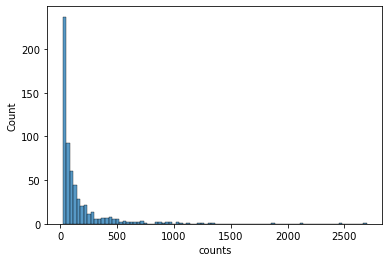

In [48]:
sns.histplot(counts.counts)

In [134]:
thresh = counts.counts.quantile(.75)

In [65]:
idx = counts[counts.counts >= thresh]['userId'].values
idx.shape, movies_with_ratings.shape
movies_with_ratings = movies_with_ratings[movies_with_ratings['userId'].isin(idx)]
movies_with_ratings.shape

(33526, 6)

In [66]:
dataset = pd.DataFrame({
    'uid': movies_with_ratings.userId,
    'iid': movies_with_ratings.title,
    'rating': movies_with_ratings.rating
})

In [67]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(dataset, reader)
# reader = Reader(rating_scale=(0.5, 5.0))
# data = Dataset.load_builtin(name=u'ml-1m',)

In [68]:
trainset, testset = train_test_split(data, test_size=.15, random_state=42)
#del ratings, movies, dataset , movies_with_ratings
gc.collect()

23

In [71]:
%%time
algo_0 = SVDpp(n_factors=20, n_epochs=20,)
algo_1 = SVD(n_factors=20, n_epochs=20,)

algo_2 = KNNWithMeans(k=30, min_k=2, sim_options={
    # 'name': 'cosine',
   'name': 'pearson_baseline',
   'user_based': False})
algos = [algo_0, algo_1, algo_2]
for algo in algos:
    algo.fit(trainset)
    test_pred = algo.test(testset)
    print(accuracy.rmse(test_pred, verbose=True))

RMSE: 0.8321
0.8320565416340803
RMSE: 0.8444
0.8444486138277318
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8736
0.8735739965462057
CPU times: user 7min 27s, sys: 1.15 s, total: 7min 28s
Wall time: 7min 29s


Для рекомендательной системы оставим первые два алгоритма, исходя и з результатов на тестовой выборке.

In [101]:
algos = algos[:2]
algos

## Content-based

In [72]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [73]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [74]:
movie_genres = [change_string(g) for g in movies.genres.values]

In [79]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(movie_genres)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

neigh = NearestNeighbors(n_neighbors=20, n_jobs=-1, metric='euclidean') 
neigh.fit(X_train_tfidf)
title_genres = {}
for index, row in tqdm(movies.iterrows()):
    title_genres[row.title] = row.genres

## Hybrid recc

In [89]:
movies_with_ratings = movies.join(ratings.set_index('movieId'), on='movieId').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)

In [139]:
def recommend_for_user(user_id, hard_userbased=False):
    current_user_id = user_id
    user_movies = movies_with_ratings[movies_with_ratings.userId == current_user_id].title.unique()
    last_user_movie = user_movies[-1]
    movie_genres = title_genres[last_user_movie]
    movie_genres = change_string(movie_genres)
    predict = count_vect.transform([movie_genres])
    X_tfidf2 = tfidf_transformer.transform(predict)

    res = neigh.kneighbors(X_tfidf2, return_distance=True)
    
    movies_to_score = movies.iloc[res[1][0]].title.values
    
    if (user_movies.shape[0] >= thresh) or hard_userbased:

        scores = []
        titles = []

        for algo in algos:
            for movie in movies_to_score:
                if movie in user_movies:
                    continue

                scores.append(algo.predict(uid=current_user_id, iid=movie).est)
                titles.append(movie)


        predict = pd.DataFrame(np.array([titles, scores]).T, )
        predict.columns=['title', 'raiting']

        return predict.groupby('title').sum().sort_values('raiting', ascending=False).head(10)
    
    else:
        return movies_to_score

In [140]:
recommend_for_user(2.0)

array(['Requiem for the American Dream (2015)', 'Into the Abyss (2011)',
       'Haunted World of Edward D. Wood Jr., The (1996)',
       'Mayor of the Sunset Strip (2003)', 'Get Me Roger Stone (2017)',
       'Samsara (2011)', 'Searching for Sugar Man (2012)',
       'Paradise Lost 3: Purgatory (2011)',
       'Nobody Speak: Hulk Hogan, Gawker and Trials of a Free Press (2017)',
       '6 Days to Air: The Making of South Park (2011)',
       'Source, The (1999)',
       'GLOW: The Story of the Gorgeous Ladies of Wrestling (2012)',
       'Comandante (2003)', 'Filth and the Fury, The (2000)',
       "Waiting for 'Superman' (2010)", 'Queen of Versailles, The (2012)',
       'Enron: The Smartest Guys in the Room (2005)',
       'For the Bible Tells Me So (2007)',
       'My Kid Could Paint That (2007)', 'Tomorrow (2015)'], dtype=object)

In [142]:
recommend_for_user(2.0, hard_userbased=True)

,raiting
title,
Searching for Sugar Man (2012),3.42900143164422033.39108441054108
Samsara (2011),3.375181830247743.35053350073552
My Kid Could Paint That (2007),3.3738583172364043.363317927273063
Tomorrow (2015),3.3661332192578143.3269873532578855
"Nobody Speak: Hulk Hogan, Gawker and Trials of a Free Press (2017)",3.3544569415242333.3186215895422277
Waiting for 'Superman' (2010),3.31810964477602033.2959066398962578
6 Days to Air: The Making of South Park (2011),3.3004541533978763.2927388095026737
Enron: The Smartest Guys in the Room (2005),3.27677185289466173.248242639750661
Mayor of the Sunset Strip (2003),3.26887613961803953.268666278116715
